# Quantum Teleportation

## 1. Statement Overview

Lets say a person called Alice wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$ to Bob. This entails passing on information about $\alpha$ and $\beta$ to Bob.

Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob because of the no-cloning theorem, which states that you cannot simply make an exact copy of an unknown quantum state. We are limited to copying only classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. After the transfer, Bob will have $\vert\psi\rangle$ and Alice won't. This is called Quantum Teleportation.

## 2. Simulating Quantum Teleportation

To transfer a quantum bit, Alice and Bob must use a third party to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit. The process is as follows:

### Step 1
A third party, Telamon, creates an entangled Bell pair of qubits and gives one to Bob and one to Alice. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

### Step 2 

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$

### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [1]:
# Install required libraries
%pip install numpy qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 2.8 MB/s 
     |████████████████████████████████| 18.0 MB 362 kB/s 
     |████████████████████████████████| 240 kB 48.4 MB/s 
     |████████████████████████████████| 112 kB 33.6 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 1.6 MB 37.6 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 943 kB 55.1 MB/s 
     |████████████████████████████████| 37.5 MB 47 kB/s 
     |████████████████████████████████| 4.0 MB 26.6 MB/s 
     |████████████████████████████████| 112 kB 56.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.2-py3-none-any.whl size=12109 sha256=ce4bddf95c24ca83affd7b7e84a80f0af5eedcc0d339736a424be98cc4d602f4
  Stored in directory: /root/.cache/pip/wheels/e6/bd/f3/26c31c

In [2]:
# Import required libraries
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

In [3]:
def entangle(qc, a, b):
    # Qubit a is Alice's while qubit b is Bob's
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
def measure(qc, a, b):
    # Measures qubits a & b and save to classical bits 0 and 1
    qc.measure(a,0)
    qc.measure(b,1)

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a) # CNOT with psi as control and a as target
    qc.h(psi) # Put psi into state |+>

In [6]:
def bob_gates(qc, qubit, crz, crx):
    # Uses qubit and classical bits to decide which gates to apply    
    # c_if is used to control our gates with a classical bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gate x if first classical bit is at 1
    qc.z(qubit).c_if(crz, 1) # Apply gate y if second classical bit is at 1

<IPython.core.display.Latex object>

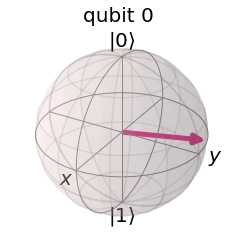

In [7]:
# Create random 1-qubit state using random_statevector. This will be the information being teleported
psi = random_statevector(2)

# Show qubit state on a Bloch sphere
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [8]:
# Initialize psi in circuit
init_gate = Initialize(psi)
init_gate.label = "init"

In [9]:
#----BEGIN QUANTUM TELEPORTATION PROTOCOL----#

# Qubit 0 (psi) is Alice's qubit which holds the information to be teleported, Qubit 1 (a) is Alice's placeholder, 
# Qubit 2 (b) is Bob's qubit which will contain the teleported information
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
classic_z = ClassicalRegister(1, name="crz") # and 2 classical registers
classic_x = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, classic_z, classic_x)

## STEP 0
# Initialize Alice's q0 information
qc.append(init_gate, [0])

## STEP 1
# Entangle q1 and q2
entangle(qc, 1, 2)

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, classic_z, classic_x)

# Display the circuit
qc.draw()

┌────────────────────────────────────────────┐          ┌───┐┌─┐       »
  q_0: ┤ init(-0.014446+0.68581j,-0.65595-0.31494j) ├───────■──┤ H ├┤M├───────»
       └───────────────────┬───┬────────────────────┘     ┌─┴─┐└┬─┬┘└╥┘       »
  q_1: ────────────────────┤ H ├───────────────────────■──┤ X ├─┤M├──╫────────»
                           └───┘                     ┌─┴─┐└───┘ └╥┘  ║  ┌───┐ »
  q_2: ──────────────────────────────────────────────┤ X ├───────╫───╫──┤ X ├─»
                                                     └───┘       ║   ║  └─╥─┘ »
crz: 1/══════════════════════════════════════════════════════════╬═══╩════╬═══»
                                                                 ║   0 ┌──╨──┐»
crx: 1/══════════════════════════════════════════════════════════╩═════╡ 0x1 ╞»
                                                                 0     └─────┘»
«              
«  q_0: ───────
«              
«  q_1: ───────
«        ┌───┐ 
«  q_2: ─┤ Z ├─
«        └─╥─┘ 
«       ┌──╨──┐
«crz: 1/╡ 0x1 ╞
«       └─────┘
«crx: 1/═══════
«

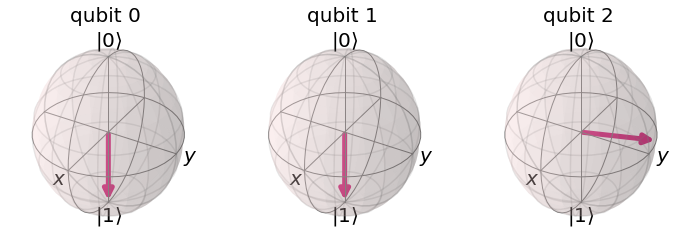

In [10]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

We can see below, using the statevector obtained from the aer simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2. Alice's qubit has now teleported to Bob.